In [2]:
import os, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.interpolate import interp1d

In [3]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')

In [134]:
from matplotlib.backends.backend_pdf import PdfPages

In [135]:
from src.utils.path import find
from src.utils.auxiliary import flatten_series

In [133]:
import json
with open('/home/niell_lab/Desktop/movclusts.json', 'r') as fp:
    movclusts = json.load(fp)

In [5]:
session_path = '/home/niell_lab/Desktop/Sn_onset_ex_data'
Sn_path = os.path.join(session_path, 'Sn')
Wn_path = os.path.join(session_path, 'Wn')
LtDk_path = os.path.join(session_path, 'LtDk')

In [6]:
Sn_world = xr.open_dataset(find('*_world.nc', Sn_path)[0])
Sn_ephys = pd.read_hdf(find('*_ephys_props.h5', Sn_path)[0])

In [127]:
Wn_ephys = pd.read_hdf(find('*_ephys_props.h5', Wn_path)[0])

In [7]:
vid = Sn_world.WORLD_video.values.astype(np.uint8)
worldT = Sn_world.timestamps.values

In [8]:
vid.shape

(16525, 120, 160)

# When does the stimulus change?

In [51]:
dStim = np.sum(np.diff(vid, axis=0), axis=(1,2))
# dStim = (dStim - np.mean(dStim,0)) / np.max(dStim, 0)

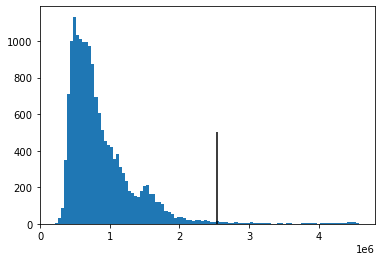

In [52]:
plt.hist(dStim, bins=100)
plt.vlines(np.std(dStim)*5, 0, 500, color='k')

(0.0, 300.0)

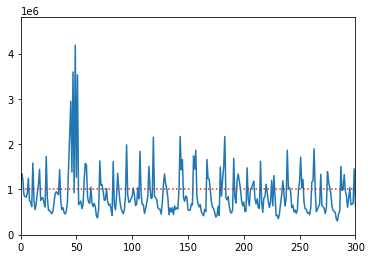

In [56]:
# thresh = np.nanmean(dStim) + (np.std(dStim)*0.75)
thresh = 1e6

plt.plot(dStim)
plt.hlines(thresh, 0, len(dStim), colors='tab:red', linestyle='dotted')

plt.xlim([0,60*5])

In [57]:
dS1 = dStim.copy()

In [62]:
from scipy.signal import argrelmax

In [88]:
flips = argrelmax(dS1, order=7)

(0.0, 200.0)

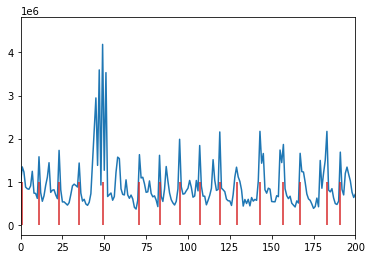

In [89]:
plt.plot(dS1)
plt.vlines(flips, 0, 1e6, colors='tab:red')
plt.xlim(0,200)

In [99]:
med_dT = np.median(np.diff(flips))/60*1000

In [100]:
print('stim changes every '+str(med_dT)+' msec')

stim changes every 200.0 msec


In [102]:
flipT = worldT[flips]
flipT

array([37839.258585, 37839.419084, 37839.619942, ..., 38148.289804,
       38148.490457, 38148.658304])

# What do neurons do when the stimulus changes?

In [103]:
model_dt = 0.025
trange = np.arange(-1, 1.1, model_dt)
trange_x = 0.5*(trange[0:-1]+ trange[1:])

In [105]:
ephysT0 = Sn_ephys['t0'].iloc[0]

In [106]:
eventT = flipT - ephysT0

In [179]:
def calc_psth(spikeT, ind, eventT):
    psth = np.zeros(trange.size-1)
    for s in np.array(eventT):
        hist, _ = np.histogram(spikeT-s, trange)
        psth = psth + hist / (psth.size*np.diff(trange))
    return psth

In [108]:
Sn_ephys.index.values

array([  7,  30,  31,  32,  34,  36,  38,  42,  44,  45,  55,  57,  58,
        60,  63,  64,  70,  71,  80,  83,  85,  89,  91,  95,  96, 104,
       106, 107, 110, 122, 126, 127, 128, 130, 137, 147, 156, 168, 170,
       172, 174, 176, 178, 184, 185, 189, 191, 192, 198, 207, 211, 219,
       232, 241, 243, 244, 247, 249, 256, 258, 260, 263, 269, 270, 284,
       287, 297, 298, 301, 304, 305, 308, 310, 311, 312, 313, 315, 316,
       317, 321, 326, 327, 330, 336, 337, 338, 343, 366, 368, 376, 377,
       380, 381, 382, 384, 388, 404, 406, 408, 419, 423, 424, 425, 429,
       430, 435, 436, 438, 441, 442, 448, 449, 456, 481, 503, 511, 515,
       516, 520, 529, 530, 531, 533, 534, 537, 541, 545, 549])

In [124]:
testpsth = calc_psth(Sn_ephys, 80, eventT)

Text(0, 0.5, 'sp/sec')

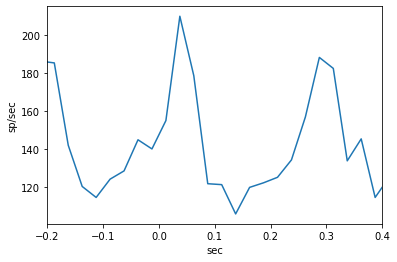

In [126]:
plt.plot(trange_x, testpsth)
plt.xlim([-0.2,0.4])
plt.xlabel('sec'); plt.ylabel('sp/sec')

# Where is the receptive field? What is on the receptive field at each stimulus change?

In [159]:
tx = 80
ty = 105

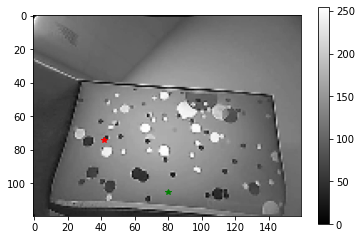

In [162]:
plt.imshow(vid[100], cmap='gray')
plt.colorbar()
plt.plot(unitx, unity, 'r*')
plt.plot(tx,ty,'g*')

In [163]:
vid[100,80,105]

149

In [178]:
def calc_RF_stim(unit_sta, vid):
    flat_unit_sta = unit_sta.copy().flatten()
    x, y = np.unravel_index(np.argmax(flat_unit_sta), unit_sta.shape)
    stim_history = vid[:,x*2,y*2]
    return stim_history, x*2, y*2

In [169]:
# test with one unit
ind = 80

In [170]:
unit_sta = Wn_ephys.loc[ind, 'Wn_spike_triggered_average']
unit_spikes = Sn_ephys.loc[ind,'spikeT']
unit_stim, unitx, unity = calc_RF_stim(unit_sta, vid)

In [219]:
flips

(array([    1,    11,    23, ..., 16499, 16511, 16521]),)

array([ 96,  95, 100, ..., 187,  93,  96], dtype=uint8)

In [222]:
def sort_lum(unit_stim, eventT, eyeT, flips, gray=149):
    event_eyeT = np.zeros(len(eventT))
    for i, t in enumerate(eventT):
        event_eyeT[i] = np.min(np.abs(t-eyeT))
    l2d = event_eyeT.copy(); d2l = event_eyeT.copy()
    l2d = l2d[unit_stim[flips]<gray] # light-to-dark transitions, as a timestamp in ephys eyeT timebase
    d2l = d2l[unit_stim[flips]>gray] # same for dark-to-light transitions
    return l2d, d2l

In [223]:
eyeT = Sn_ephys['Sn_eyeT'].iloc[0]

In [224]:
stimT = worldT - ephysT0

In [227]:
from tqdm import tqdm

In [228]:
Sn_psth = np.zeros([len(Sn_ephys.index.values), len(trange_x), 2]) # shape = [unit#, time, ltd or d2l]
for i, ind in tqdm(enumerate(Sn_ephys.index.values)):
    unit_sta = Wn_ephys.loc[ind, 'Wn_spike_triggered_average']
    unit_stim, _, _ = calc_RF_stim(unit_sta, vid)
    l2d_eventT, d2l_eventT = sort_lum(unit_stim, eventT, eyeT, flips)
    unit_spikeT = Sn_ephys.loc[ind, 'spikeT']
    Sn_psth[i,:,0] = calc_psth(unit_spikeT, ind, l2d_eventT)
    Sn_psth[i,:,1] = calc_psth(unit_spikeT, ind, d2l_eventT)

128it [00:09, 14.21it/s]


In [229]:
Sn_psth.shape

(128, 83, 2)

# PDF of all units

In [ ]:
exc_or_inh

In [ ]:
pdf = PdfPages('/home/niell_lab/Desktop/sparsenoise_psth.pdf')
for name in ['early','late','biphasic','negative','unresponsive']:
    use_units = [int(key) for key,val in movclusts.items() if val==name]
    celldata = revcheck_responses(exc_or_inh, pdf, celldata, onset0_eyeT, onset1_eyeT, onset1_world_inds, vid, sta, leftsacc, rightsacc, movclusts, use_units)
pdf.close()

In [ ]:
for name in names()
for i in np.size(Sn_psth,0):
    

In [ ]:
for i, ind in enumerate(Sn_ephys.index.values):
    unit_sta = Wn_ephys.loc[ind, 'Wn_spike_triggered_average']
    